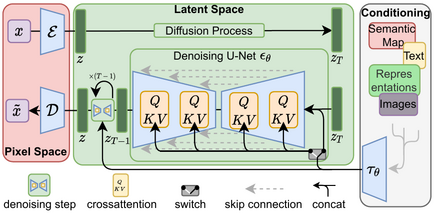

 feeding additional information to the UNet allows us to have some additional control over the types of images generated. We call this conditioning. Given a noisy version of an image, the model is tasked with predicting the denoised version based on additional clues such as a class label or, in the case of Stable Diffusion, a text description of the image. At inference time, we can feed in the description of an image we’d like to see and some pure noise as a starting point, and the model does its best to ‘denoise’ the random input into something that matches the caption. [https://huggingface.co/learn/diffusion-course/en/unit3/1#:~:text=feeding%20additional%20information,matches%20the%20caption.]

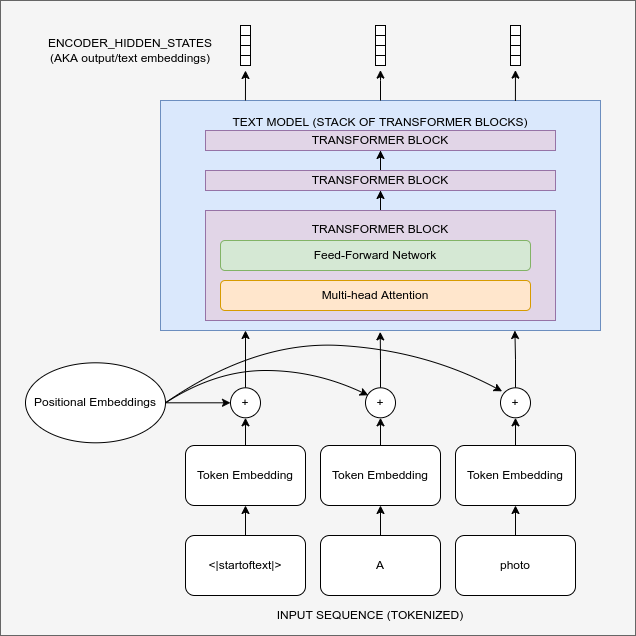

SD leverages a pre-trained transformer model based on something called CLIP. CLIP’s text encoder was designed to process image captions into a form that could be used to compare images and text, so it is well suited to the task of creating useful representations from image descriptions. An input prompt is first tokenized (based on a large vocabulary where each word or sub-word is assigned a specific token) and then fed through the CLIP text encoder, producing a 768-dimensional (in the case of SD 1.X) or 1024-dimensional (SD 2.X) vector for each token. To keep things consistent prompts are always padded/truncated to be 77 tokens long, and so the final representation which we use as conditioning is a tensor of shape 77x1024 per prompt.

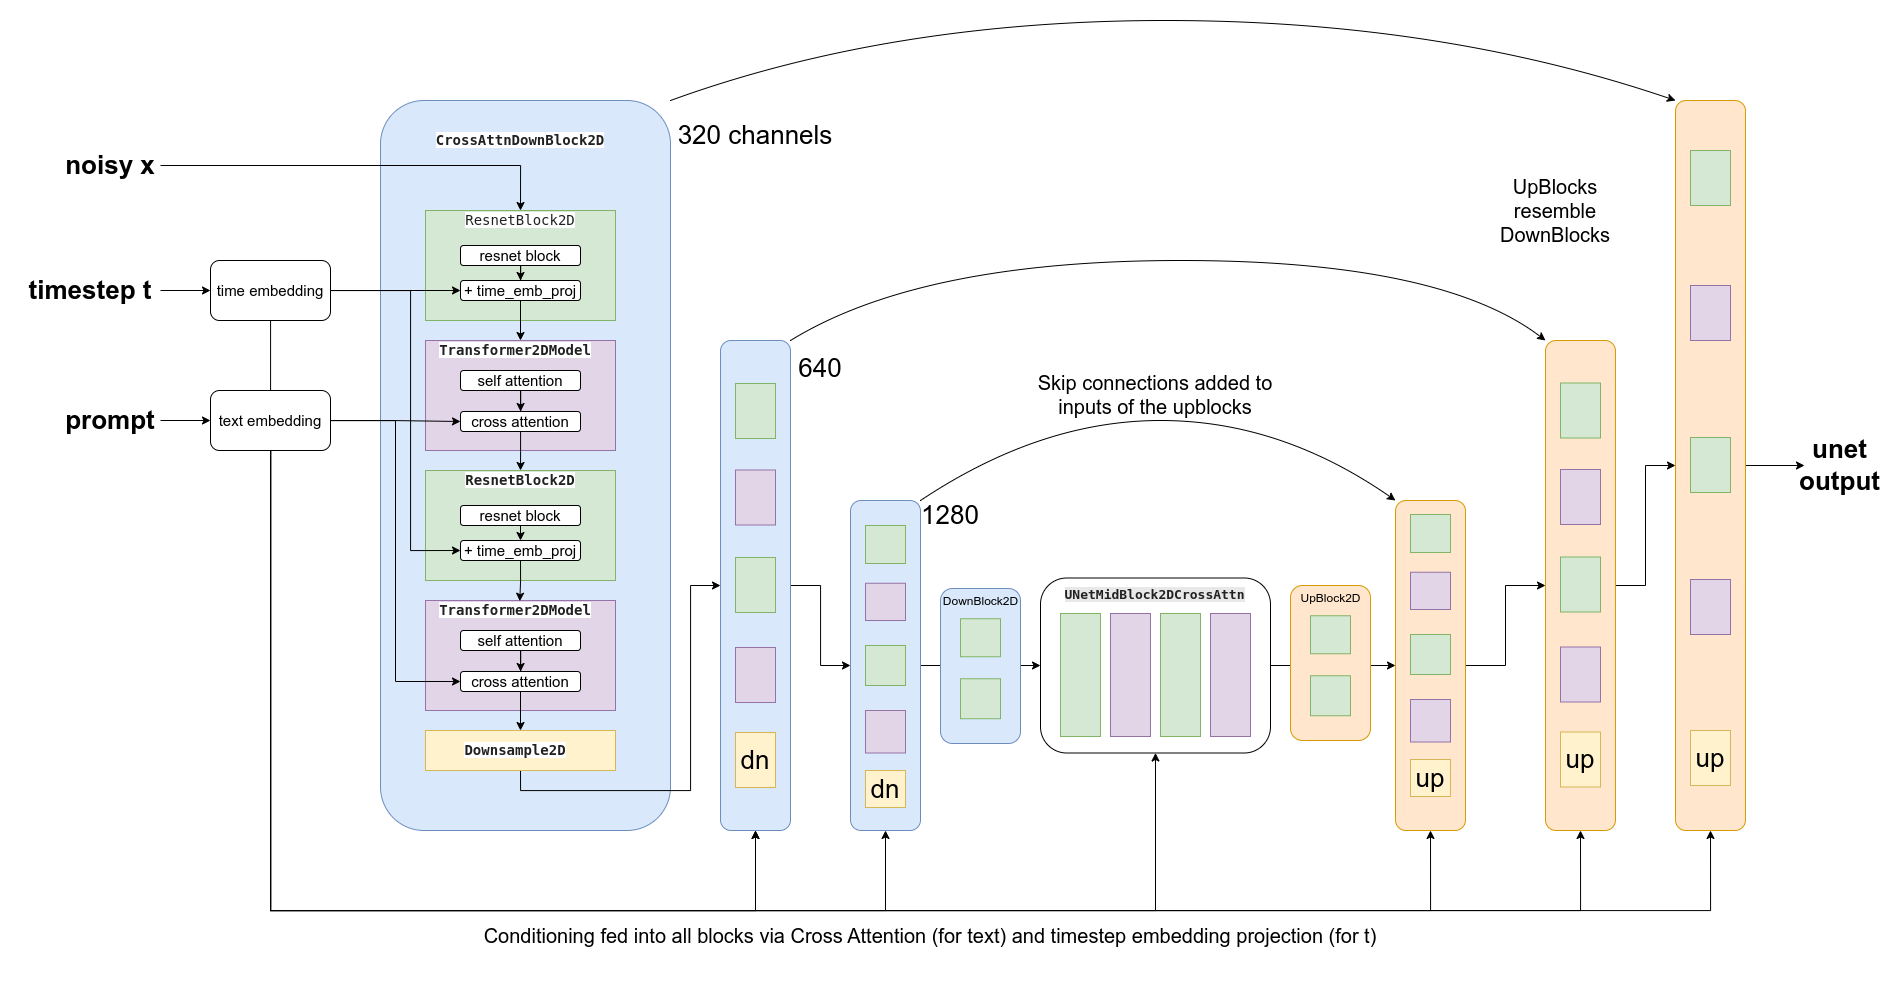

OK, so how do we actually feed this conditioning information into the UNet for it to use as it makes predictions? The answer is something called cross-attention. Scattered throughout the UNet are cross-attention layers. Each spatial location in the UNet can ‘attend’ to different tokens in the text conditioning, bringing in relevant information from the prompt. The diagram above shows how this text conditioning (as well as timestep-based conditioning) is fed in at different points. As you can see, at every level the UNet has ample opportunity to make use of this conditioning!

In [1]:
from diffusers import AutoencoderKL, DDIMScheduler, UNet2DConditionModel
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")

scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

vae.to(device)
unet.to(device)
text_encoder.to(device)


CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [30]:
prompt = ["A cat"]

tokenized_prompt = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

print(f'shape of  tokenized_prompt: {tokenized_prompt.input_ids.shape}')
# Move to the same device as the model.
tokenized_prompt = tokenized_prompt.to(device)

# Encode the text and get the text embeddings.
with torch.no_grad():
    text_embeddings = text_encoder(**tokenized_prompt).last_hidden_state

print(f'shape of text_embeddings: {text_embeddings.shape}')

shape of  tokenized_prompt: torch.Size([1, 77])
shape of text_embeddings: torch.Size([1, 77, 768])


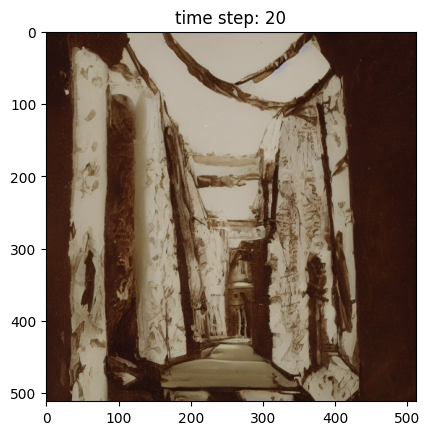

In [33]:
# set the inference time steps to be 50
scheduler.set_timesteps(num_inference_steps=50)

generator = torch.cuda.manual_seed_all(42)
latents = torch.randn((1, unet.in_channels, 64, 64), generator=generator, device=device).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    
    with torch.no_grad():
        # predict the noise residual
        noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings).sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
        if i%5==0:
            latents_scaled = 1 / vae.config.scaling_factor * latents
            with torch.no_grad():
                image = vae.decode(latents_scaled).sample
            
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
            
            plt.imshow(image)
            plt.title(f'time step: {t}')
            clear_output(wait=True)
            plt.show()
            
latents_scaled = 1 / vae.config.scaling_factor * latents
with torch.no_grad():
    image = vae.decode(latents_scaled).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f'time step: {t}')
clear_output(wait=True)
plt.show()



## Classifier-free Guidance
It turns out that even with all of the effort put into making the text conditioning as useful as possible, the model still tends to default to relying mostly on the noisy input image rather than the prompt when making its predictions. In a way, this makes sense - many captions are only loosely related to their associated images and so the model learns not to rely too heavily on the descriptions! However, this is undesirable when it comes time to generate new images - if the model doesn’t follow the prompt then we may get images out that don’t relate to our description at all.

In [23]:
prompt = ["A cat", ""]

tokenized_prompt = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

print(f'shape of  tokenized_prompt: {tokenized_prompt.input_ids.shape}')
# Move to the same device as the model.
tokenized_prompt = tokenized_prompt.to(device)

# Encode the text and get the text embeddings.
with torch.no_grad():
    text_embeddings = text_encoder(**tokenized_prompt).last_hidden_state

print(f'shape of text_embeddings: {text_embeddings.shape}')

shape of  tokenized_prompt: torch.Size([2, 77])
shape of text_embeddings: torch.Size([2, 77, 768])


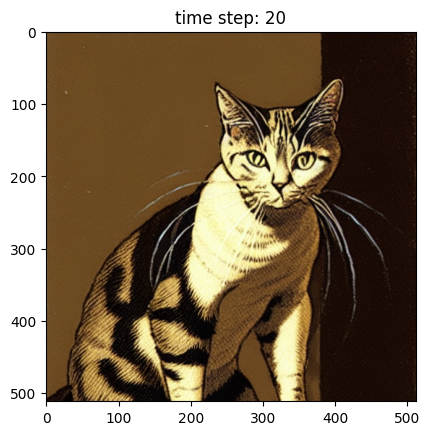

In [ ]:
# set the inference time steps to be 50
scheduler.set_timesteps(num_inference_steps=50)

guidance_scale = 7.5

generator = torch.cuda.manual_seed_all(42)
latents = torch.randn((1, unet.config.in_channels, 64, 64), generator=generator, device=device).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    
    latent_model_inputs = torch.cat([latents] * 2)
    
    with torch.no_grad():
        # predict the noise residual
        noise_pred = unet(latent_model_inputs, t, encoder_hidden_states=text_embeddings).sample
        
    # perform guidance
    noise_pred_text, noise_pred_uncond = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

    
    if i%5==0 or t==1 :
        latents_scaled = 1 / vae.config.scaling_factor * latents
        with torch.no_grad():
            image = vae.decode(latents_scaled).sample
        
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        plt.imshow(image)
        plt.title(f'time step: {t}')
        clear_output(wait=True)
        plt.show()
        
latents_scaled = 1 / vae.config.scaling_factor * latents
with torch.no_grad():
    image = vae.decode(latents_scaled).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f'time step: {t}')
clear_output(wait=True)
plt.show()

# Change The Scheduler for Better Result

In [34]:
prompt = ["A cat", ""]

tokenized_prompt = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

print(f'shape of  tokenized_prompt: {tokenized_prompt.input_ids.shape}')
# Move to the same device as the model.
tokenized_prompt = tokenized_prompt.to(device)

# Encode the text and get the text embeddings.
with torch.no_grad():
    text_embeddings = text_encoder(**tokenized_prompt).last_hidden_state

print(f'shape of text_embeddings: {text_embeddings.shape}')

shape of  tokenized_prompt: torch.Size([2, 77])
shape of text_embeddings: torch.Size([2, 77, 768])


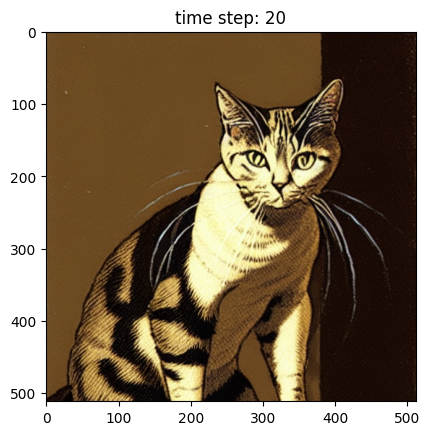

In [ ]:
from diffusers import DPMSolverMultistepScheduler

scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler", algorithm_type="sde-dpmsolver++")
scheduler.set_timesteps(num_inference_steps=50)


guidance_scale = 7.5

generator = torch.cuda.manual_seed_all(42)
latents = torch.randn((1, unet.config.in_channels, 64, 64), generator=generator, device=device).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    
    latent_model_inputs = torch.cat([latents] * 2)
    
    with torch.no_grad():
        # predict the noise residual
        noise_pred = unet(latent_model_inputs, t, encoder_hidden_states=text_embeddings).sample
        
    # perform guidance
    noise_pred_text, noise_pred_uncond = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    extra_step_kwargs = {}
    extra_step_kwargs["generator"] = torch.Generator().manual_seed(42)
    latents = scheduler.step(noise_pred, t, latents, 
                           generator = generator
                             ).prev_sample

    
    if i%5==0:
        latents_scaled = 1 / vae.config.scaling_factor * latents
        with torch.no_grad():
            image = vae.decode(latents_scaled).sample
        
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()
        
        plt.imshow(image)
        plt.title(f'time step: {t}')
        clear_output(wait=True)
        plt.show()
        
latents_scaled = 1 / vae.config.scaling_factor * latents
with torch.no_grad():
    image = vae.decode(latents_scaled).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().squeeze(0).permute(1, 2, 0).numpy()

plt.imshow(image)
plt.title(f'time step: {t}')
clear_output(wait=True)
plt.show()

# Wrap everything in a Pipeline

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

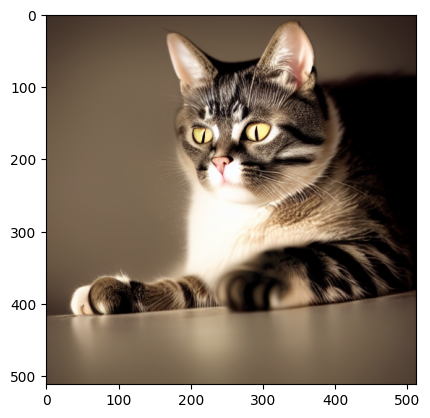

In [ ]:
from diffusers import StableDiffusionPipeline



pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=scheduler,
    safety_checker=None,
    feature_extractor=None,
)

pipeline.to(device)

prompt = "A cat"

generator = torch.cuda.manual_seed_all(42)
latents = torch.randn((1, unet.config.in_channels, 64, 64), generator=generator, device=device).to(device)

images = pipeline(
        prompt=prompt,
        negative_prompt="",
        latents=latents,
        num_inference_steps=50,
        guidance_scale=7.5,
        generator = generator,
        
    )

plt.imshow(images.images[0])
plt.show()

